In [5]:
import keras
keras.__version__

'2.2.4'

# Neural style transfer


This notebook contains the code samples found in Chapter 8, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----


Besides Deep Dream, another major development in deep learning-driven image modification that happened in the summer of 2015 is neural 
style transfer, introduced by Leon Gatys et al. The neural style transfer algorithm has undergone many refinements and spawned many 
variations since its original introduction, including a viral smartphone app, called Prisma. For simplicity, this section focuses on the 
formulation described in the original paper.

Neural style transfer consists in applying the "style" of a reference image to a target image, while conserving the "content" of the target 
image:



![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)


What is meant by "style" is essentially textures, colors, and visual patterns in the image, at various spatial scales, while the "content" 
is the higher-level macrostructure of the image. For instance, blue-and-yellow circular brush strokes are considered to be the "style" in 
the above example using Starry Night by Van Gogh, while the buildings in the Tuebingen photograph are considered to be the "content".

The idea of style transfer, tightly related to that of texture generation, has had a long history in the image processing community prior 
to the development of neural style transfer in 2015. However, as it turned out, the deep learning-based implementations of style transfer 
offered results unparalleled by what could be previously achieved with classical computer vision techniques, and triggered an amazing 
renaissance in creative applications of computer vision.

The key notion behind implementing style transfer is same idea that is central to all deep learning algorithms: we define a loss function 
to specify what we want to achieve, and we minimize this loss. We know what we want to achieve: conserve the "content" of the original image, 
while adopting the "style" of the reference image. If we were able to mathematically define content and style, then an appropriate loss 
function to minimize would be the following:

```
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))
```


Where `distance` is a norm function such as the L2 norm, `content` is a function that takes an image and computes a representation of its 
"content", and `style` is a function that takes an image and computes a representation of its "style".

Minimizing this loss would cause `style(generated_image)` to be close to `style(reference_image)`, while `content(generated_image)` would 
be close to `content(generated_image)`, thus achieving style transfer as we defined it.

A fundamental observation made by Gatys et al is that deep convolutional neural networks offer precisely a way to mathematically defined 
the `style` and `content` functions. Let's see how.

## The content loss


As you already know, activations from earlier layers in a network contain _local_ information about the image, while activations from 
higher layers contain increasingly _global_ and _abstract_ information. Formulated in a different way, the activations of the different 
layers of a convnet provide a decomposition of the contents of an image over different spatial scales. Therefore we expect the "content" of 
an image, which is more global and more abstract, to be captured by the representations of a top layer of a convnet.

A good candidate for a content loss would thus be to consider a pre-trained convnet, and define as our loss the L2 norm between the 
activations of a top layer computed over the target image and the activations of the same layer computed over the generated image. This 
would guarantee that, as seen from the top layer of the convnet, the generated image will "look similar" to the original target image. 
Assuming that what the top layers of a convnet see is really the "content" of their input images, then this does work as a way to preserve 
image content.

## The style loss


While the content loss only leverages a single higher-up layer, the style loss as defined in the Gatys et al. paper leverages multiple 
layers of a convnet: we aim at capturing the appearance of the style reference image at all spatial scales extracted by the convnet, not 
just any single scale.

For the style loss, the Gatys et al. paper leverages the "Gram matrix" of a layer's activations, i.e. the inner product between the feature maps 
of a given layer. This inner product can be understood as representing a map of the correlations between the features of a layer. These 
feature correlations capture the statistics of the patterns of a particular spatial scale, which empirically corresponds to the appearance 
of the textures found at this scale.

Hence the style loss aims at preserving similar internal correlations within the activations of different layers, across the style 
reference image and the generated image. In turn, this guarantees that the textures found at different spatial scales will look similar 
across the style reference image and the generated image.

## In short


In short, we can use a pre-trained convnet to define a loss that will:

* Preserve content by maintaining similar high-level layer activations between the target content image and the generated image. The 
convnet should "see" both the target image and the generated image as "containing the same things".
* Preserve style by maintaining similar _correlations_ within activations for both low-level layers and high-level layers. Indeed, feature 
correlations capture _textures_: the generated and the style reference image should share the same textures at different spatial scales.

Now let's take a look at a Keras implementation of the original 2015 neural style transfer algorithm. As you will see, it shares a lot of 
similarities with the Deep Dream implementation we developed in the previous section.

## Neural style transfer in Keras


Neural style transfer can be implemented using any pre-trained convnet. Here we will use the VGG19 network, used by Gatys et al in their paper. 
VGG19 is a simple variant of the VGG16 network we introduced in Chapter 5, with three more convolutional layers.

This is our general process:

* Set up a network that will compute VGG19 layer activations for the style reference image, the target image, and the generated image at 
the same time.
* Use the layer activations computed over these three images to define the loss function described above, which we will minimize in order 
to achieve style transfer.
* Set up a gradient descent process to minimize this loss function.


Let's start by defining the paths to the two images we consider: the style reference image and the target image. To make sure that all 
images processed share similar sizes (widely different sizes would make style transfer more difficult), we will later resize them all to a 
shared height of 400px.

In [6]:
from keras.preprocessing.image import load_img, img_to_array

# This is the path to the image you want to transform.
target_image_path = './img/irzaaw.jpg'
# This is the path to the style image.
style_reference_image_path = './img/portrait-of-dora-maar.jpg'

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

We will need some auxiliary functions for loading, pre-processing and post-processing the images that will go in and out of the VGG19 
convnet:

In [7]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


Let's set up the VGG19 network. It takes as input a batch of three images: the style reference image, the target image, and a placeholder 
that will contain the generated image. A placeholder is simply a symbolic tensor, the values of which are provided externally via Numpy 
arrays. The style reference and target image are static, and thus defined using `K.constant`, while the values contained in the placeholder 
of the generated image will change over time.

In [9]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

Model loaded.



Let's define the content loss, meant to make sure that the top layer of the VGG19 convnet will have a similar view of the target image and 
the generated image:

In [12]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


Now, here's the style loss. It leverages an auxiliary function to compute the Gram matrix of an input matrix, i.e. a map of the correlations 
found in the original feature matrix.

In [13]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


To these two loss components, we add a third one, the "total variation loss". It is meant to encourage spatial continuity in the generated 
image, thus avoiding overly pixelated results. You could interpret it as a regularization loss.

In [14]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


The loss that we minimize is a weighted average of these three losses. To compute the content loss, we only leverage one top layer, the 
`block5_conv2` layer, while for the style loss we use a list of layers than spans both low-level and high-level layers. We add the total 
variation loss at the end.

Depending on the style reference image and content image you are using, you will likely want to tune the `content_weight` coefficient, the 
contribution of the content loss to the total loss. A higher `content_weight` means that the target content will be more recognizable in 
the generated image.

In [15]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)


Finally, we set up the gradient descent process. In the original Gatys et al. paper, optimization is performed using the L-BFGS algorithm, 
so that is also what we will use here. This is a key difference from the Deep Dream example in the previous section. The L-BFGS algorithms 
comes packaged with SciPy. However, there are two slight limitations with the SciPy implementation:

* It requires to be passed the value of the loss function and the value of the gradients as two separate functions.
* It can only be applied to flat vectors, whereas we have a 3D image array.

It would be very inefficient for us to compute the value of the loss function and the value of gradients independently, since it would lead 
to a lot of redundant computation between the two. We would be almost twice slower than we could be by computing them jointly. To by-pass 
this, we set up a Python class named `Evaluator` that will compute both loss value and gradients value at once, will return the loss value 
when called the first time, and will cache the gradients for the next call.

In [16]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


Finally, we can run the gradient ascent process using SciPy's L-BFGS algorithm, saving the current generated image at each iteration of the 
algorithm (here, a single iteration represents 20 steps of gradient ascent):

In [17]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 2

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 958105340.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 131s
Start of iteration 1


C:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 457267360.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 130s


Here's what we get:

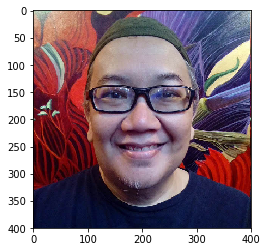

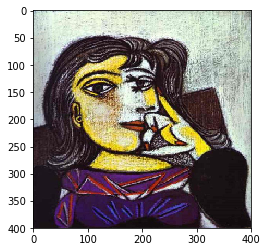

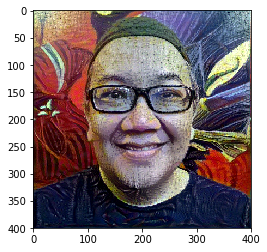

In [19]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()


Keep in mind that what this technique achieves is merely a form of image re-texturing, or texture transfer. It will work best with style 
reference images that are strongly textured and highly self-similar, and with content targets that don't require high levels of details in 
order to be recognizable. It would typically not be able to achieve fairly abstract feats such as "transferring the style of one portrait to 
another". The algorithm is closer to classical signal processing than to AI, so don't expect it to work like magic!

Additionally, do note that running this style transfer algorithm is quite slow. However, the transformation operated by our setup is simple 
enough that it can be learned by a small, fast feedforward convnet as well -- as long as you have appropriate training data available. Fast 
style transfer can thus be achieved by first spending a lot of compute cycles to generate input-output training examples for a fixed style 
reference image, using the above method, and then training a simple convnet to learn this style-specific transformation. Once that is done, 
stylizing a given image is instantaneous: it's a just a forward pass of this small convnet.


## Take aways

* Style transfer consists in creating a new image that preserves the "contents" of a target image while also capturing the "style" of a 
reference image.
* "Content" can be captured by the high-level activations of a convnet.
* "Style" can be captured by the internal correlations of the activations of different layers of a convnet.
* Hence deep learning allows style transfer to be formulated as an optimization process using a loss defined with a pre-trained convnet.
* Starting from this basic idea, many variants and refinements are possible!
